In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

from generation.dataset.signals_dataset import SignalsDataset

In [12]:
dataset = SignalsDataset(signal_size=1024)

In [13]:
 dataset.noises.shape

(9, 9860, 1024)

In [14]:
sample = dataset.noises[:, 0]

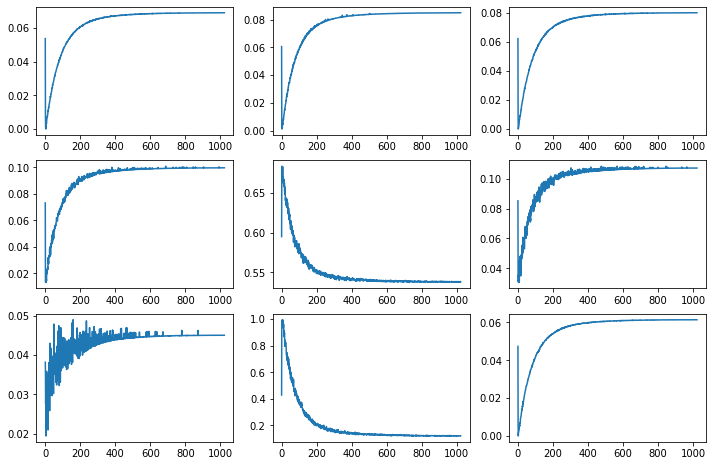

In [18]:
f, ax = plt.subplots(3, 3, figsize=(12, 8))

for i in range(9):
    ax[i // 3][i % 3].plot(sample[i])
plt.show()

In [4]:
noises1 = dataset.noises[0]
noises2 = dataset.noises[1]

$sup_f E[{p(x,y)} f(x,y)] - E[p(x)p(y) e^{f(x,y)-1}]$

In [5]:
from torch.utils.data import Dataset, DataLoader

class NoisesDataset(Dataset):
    def __init__(self, noises1, noises2):
        self.noises1 = noises1
        self.noises2 = noises2

    def __len__(self):
        return len(self.noises1)

    def __getitem__(self, idx):
        noise1_tensor = torch.from_numpy(self.noises1[idx]).float()
        noise2_tensor = torch.from_numpy(self.noises2[idx]).float()
        return noise1_tensor, noise2_tensor

In [6]:
dataset = NoisesDataset(noises1, noises2)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 16)
        self.fc3 = nn.Linear(16, 1)
    
    def forward(self, signal1, signal2):
        x = signal1.unsqueeze(0) - signal2.unsqueeze(0)
#         print(x.shape)
        x = F.leaky_relu(self.fc1(x))
#         print(x.shape)
        x = F.leaky_relu(self.fc2(x))
#         print(x.shape)
        x = self.fc3(x)
        return x

In [8]:
def compute_loss(model, noises1, noises2, size=200):
    first = 0
    second = 0
    bs = len(noises1)
    prob = 1 / bs**2 
    for noise1 in noises1:
        for noise2 in noises2:
            val = model(noise1, noise2)
            first +=  val * prob
            second = prob * torch.exp(val - 1)
    return first - second

In [9]:
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [10]:
for idx, item in enumerate(tqdm.tqdm(dataloader)):
    optimizer.zero_grad()
    noise1, noise2 = item
    loss = compute_loss(model, noise1, noise2)
    loss.backward()
    optimizer.step()
    if idx % 10 == 0:
        print(idx, round(loss.item(), 3))

  0%|          | 1/1233 [00:03<1:03:05,  3.07s/it]

0 0.25


  1%|          | 11/1233 [00:14<29:39,  1.46s/it] 

10 0.192


  2%|▏         | 21/1233 [00:24<14:36,  1.38it/s]

20 0.123


  3%|▎         | 31/1233 [00:34<22:10,  1.11s/it]

30 0.041


  3%|▎         | 41/1233 [00:40<11:41,  1.70it/s]

40 -0.139


  4%|▍         | 51/1233 [00:54<23:23,  1.19s/it]

50 -0.286


  5%|▍         | 61/1233 [01:00<11:49,  1.65it/s]

60 -0.902


  6%|▌         | 71/1233 [01:08<15:44,  1.23it/s]

70 -1.326


  7%|▋         | 81/1233 [01:14<11:34,  1.66it/s]

80 -2.202


  7%|▋         | 91/1233 [01:22<15:51,  1.20it/s]

90 -3.961


  8%|▊         | 101/1233 [01:31<19:06,  1.01s/it]

100 -3.62


  9%|▉         | 111/1233 [01:40<22:35,  1.21s/it]

110 -5.855


 10%|▉         | 121/1233 [01:48<20:54,  1.13s/it]

120 -7.254


 11%|█         | 131/1233 [01:57<15:21,  1.20it/s]

130 -7.966


 11%|█▏        | 141/1233 [02:03<10:38,  1.71it/s]

140 -12.314


 12%|█▏        | 151/1233 [02:11<12:06,  1.49it/s]

150 -15.65


 13%|█▎        | 161/1233 [02:17<10:27,  1.71it/s]

160 -15.102


 14%|█▍        | 171/1233 [02:29<23:21,  1.32s/it]

170 -23.378


 15%|█▍        | 181/1233 [02:37<13:17,  1.32it/s]

180 -30.396


 15%|█▌        | 191/1233 [02:43<10:06,  1.72it/s]

190 -29.516


 16%|█▋        | 201/1233 [02:53<21:36,  1.26s/it]

200 -33.415


 17%|█▋        | 211/1233 [03:00<10:31,  1.62it/s]

210 -61.389


 18%|█▊        | 221/1233 [03:08<10:50,  1.56it/s]

220 -52.947


 19%|█▊        | 231/1233 [03:21<23:47,  1.42s/it]

230 -56.041


 20%|█▉        | 241/1233 [03:29<10:45,  1.54it/s]

240 -64.919


 20%|██        | 251/1233 [03:38<21:08,  1.29s/it]

250 -73.109


 21%|██        | 261/1233 [03:53<25:38,  1.58s/it]

260 -81.491


 22%|██▏       | 271/1233 [04:02<15:15,  1.05it/s]

270 -116.521


 23%|██▎       | 281/1233 [04:15<14:53,  1.07it/s]

280 -126.911


 24%|██▎       | 291/1233 [04:21<10:09,  1.54it/s]

290 -117.57


 24%|██▍       | 301/1233 [04:28<09:29,  1.64it/s]

300 -186.438


 25%|██▌       | 311/1233 [04:34<09:19,  1.65it/s]

310 -130.079


 26%|██▌       | 321/1233 [04:41<11:35,  1.31it/s]

320 -129.128


 27%|██▋       | 331/1233 [04:51<14:03,  1.07it/s]

330 -156.712


 28%|██▊       | 341/1233 [04:57<10:24,  1.43it/s]

340 -192.853


 28%|██▊       | 351/1233 [05:04<09:07,  1.61it/s]

350 -201.113


 29%|██▉       | 361/1233 [05:11<11:33,  1.26it/s]

360 -274.217


 30%|███       | 371/1233 [05:17<08:25,  1.70it/s]

370 -271.392


 31%|███       | 378/1233 [05:22<12:08,  1.17it/s]


KeyboardInterrupt: 

In [7]:
model = Net()
s1 = torch.from_numpy(noises1[0]).float()
s2 = torch.from_numpy(noises2[0]).float()

In [8]:
model(s1, s2)

torch.Size([1, 1024])
torch.Size([1, 256])
torch.Size([1, 16])


tensor([[0.0943]], grad_fn=<AddmmBackward>)

In [34]:
foo = lambda x, y: np.mean((x - y)**2)

In [35]:
compute_metric(foo, noises1, noises2)

100%|██████████| 200/200 [00:01<00:00, 176.61it/s]


0.0010694427317523736

In [7]:
foo(noises1[0], noises2[0])

0.00023958933059962093